<h2>Plotting Simulation Differences</h2>

This example demonstrates how to use wrf-python to plot the differences between two output times for one simulation. The same logic applies the plotting the differences between two simulations at a given output time. This example is drawn from the Plotting 2D Fields example, using data from 2100 UTC 7 October 2016 and 0000 UTC 8 October 2016 from the Hurricane Matthew tutorial case, although the logic also applies to 3D fields.

More information on how to use wrf-python is available at https://wrf-python.readthedocs.io/en/main/basic_usage.html.

<hr>

We start by importing the needed modules. These are drawn from five packages - netCDF4, matplotlib, numpy, cartopy, and wrf (short for wrf-python).

In [6]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.ticker as mticker
import numpy as np
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)

Open the desired wrfout files. Note that each file in this example contains data only for a single output time. If all output times are in a single file, then only one file needs to be opened, with the xarray sel() function used twice to select only the desired times for each desired variable.

In [7]:
ncfile1 = Dataset("wrfout_d01_2016-10-07_21:00:00")
ncfile2 = Dataset("wrfout_d01_2016-10-08_00:00:00")

Extract the sea-level pressure, 10-m zonal wind, and 10-m meridional wind from the wrfout files. Note that these are fields that wrf-python derives from the model output; the full list of variables that wrf-python can derive is available at https://wrf-python.readthedocs.io/en/latest/user_api/generated/wrf.getvar.html.

The uvmet10 derived variable returns u as its 0th argument and v as its 1th argument.

We also smooth the sea-level pressure fields using wrf-python's smooth2d helper function. Other smoothing functions are available as part of the scipy package.

In [13]:
slp1 = getvar(ncfile1, "slp")
slp2 = getvar(ncfile2, "slp")
smooth_slp1 = smooth2d(slp1, 3, cenweight=4)
smooth_slp2 = smooth2d(slp2, 3, cenweight=4)

u10_1 = getvar(ncfile1, "uvmet10", units="kt")[0,:]
u10_2 = getvar(ncfile2, "uvmet10", units="kt")[0,:]
v10_1 = getvar(ncfile1, "uvmet10", units="kt")[1,:]
v10_2 = getvar(ncfile2, "uvmet10", units="kt")[1,:]

Next, we get the latitude and longitude points, as defined by the sea-level pressure variable's coordinates. We also get the model's map projection, as defined by the sea-level pressure variable's attributes. Note that we only need to do this once since the simulation domain is identical between output times, and we only need to do this from one variable since the domain information is identical between variables.

In [9]:
lats, lons = latlon_coords(slp1)
cart_proj = get_cartopy(slp1)

The remainder of the plot-generation code is contained in a single code block below. This is due to a Python quirk; a map-based figure is generated before we add any data to it if we try to break the code up into separate code blocks. Please see the comment blocks below to interpret the code.

/opt/tljh/user/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


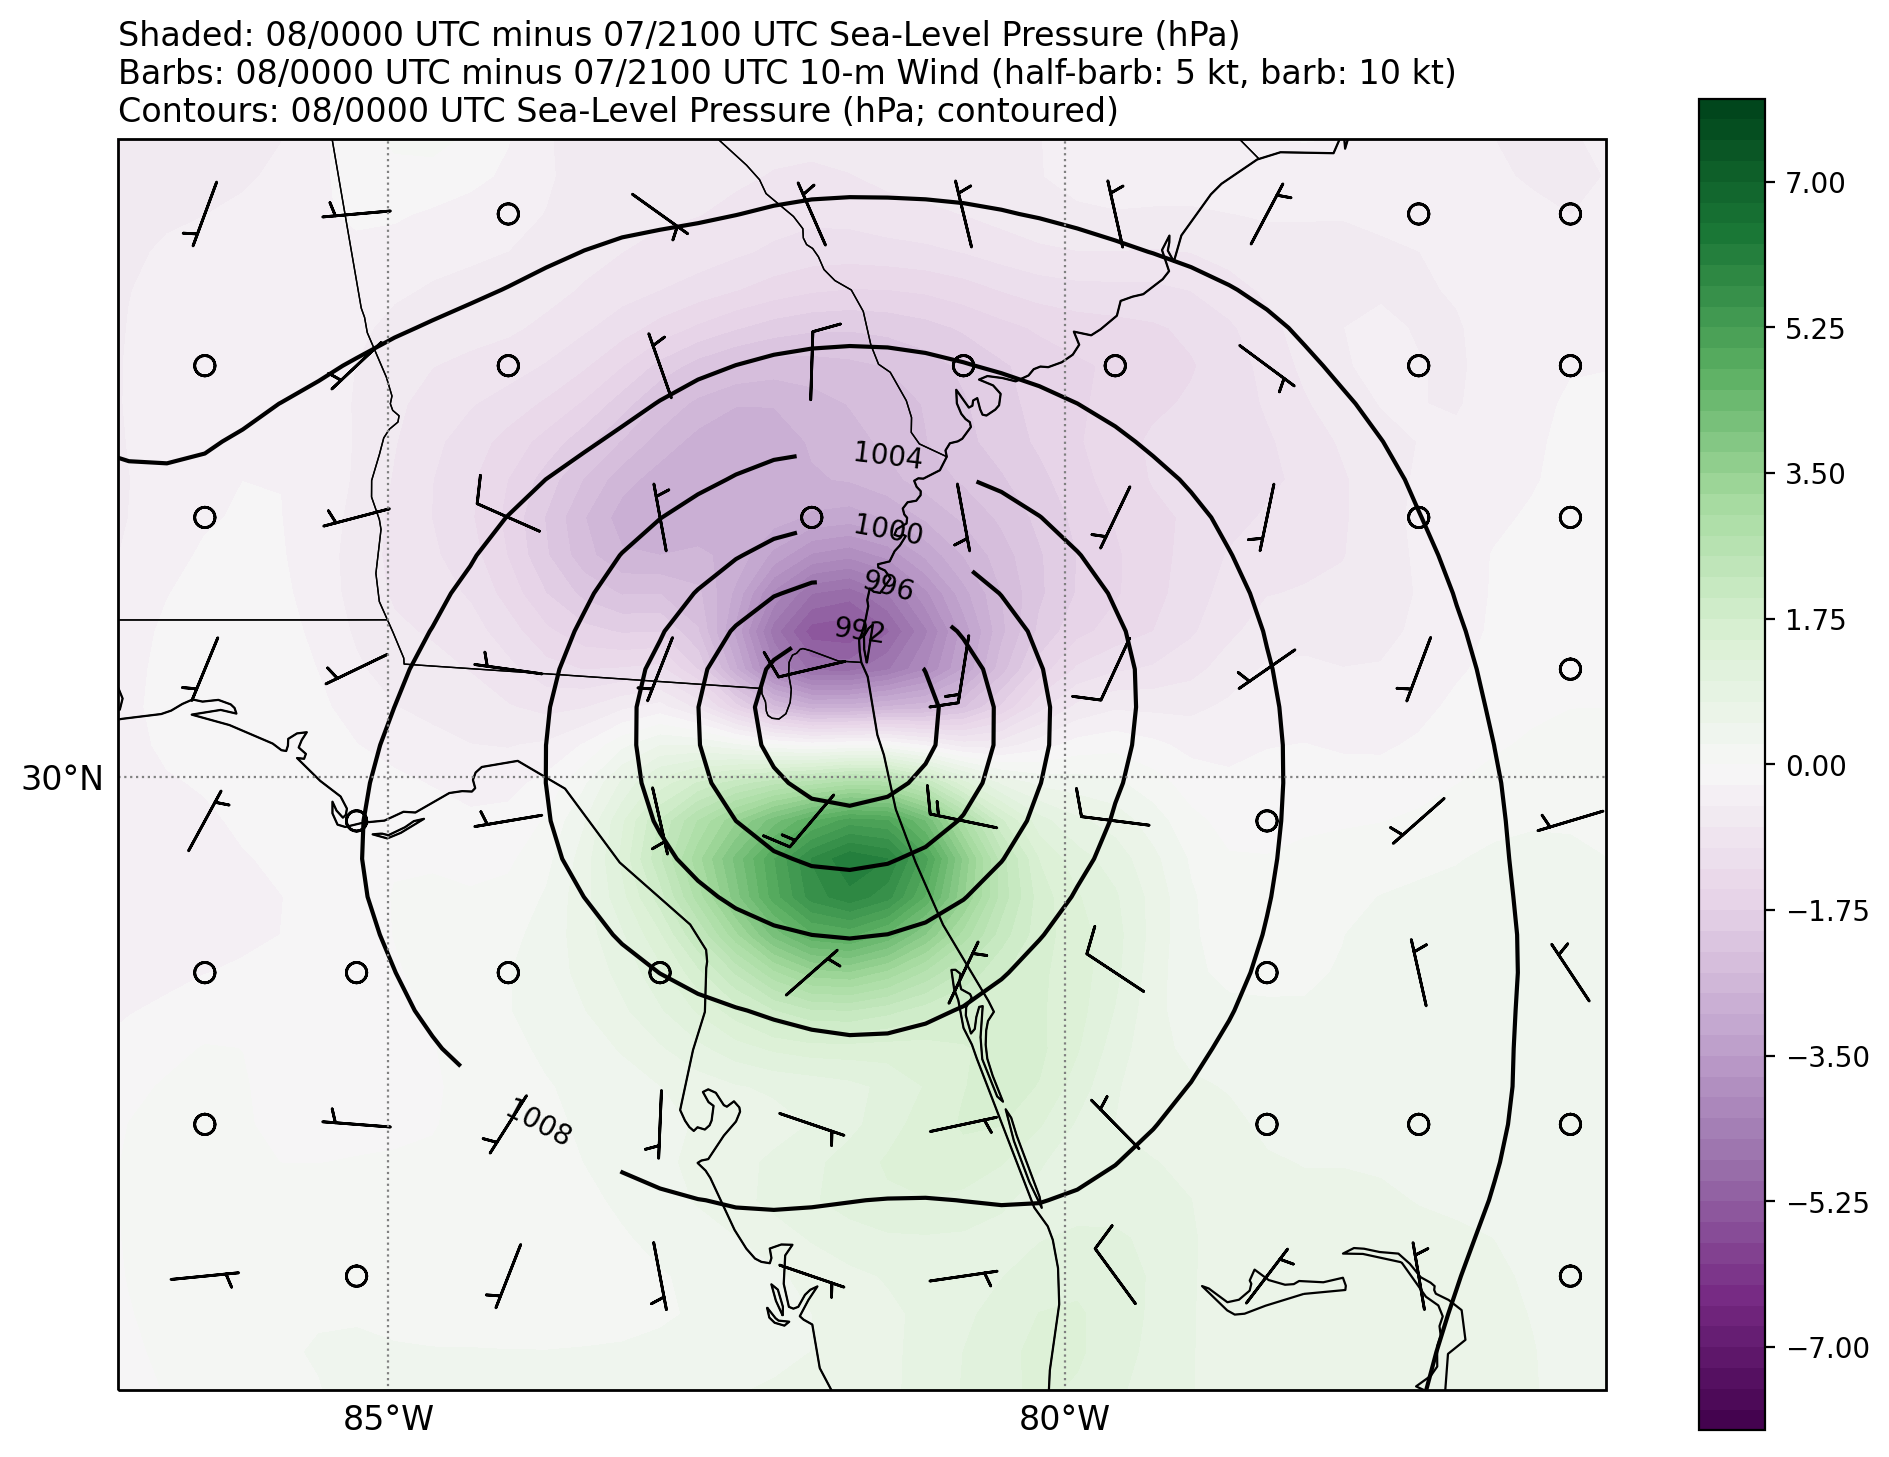

In [22]:
# Create a figure instance.
fig = plt.figure(figsize=(12,9), dpi=200.)

# Create a set of axes for the figure and set
# its map projection to that from the slp variable,
# which matches WRF's map projection.
ax = plt.axes(projection=cart_proj)

# Add state borders and coastlines.
# These commands automatically download the needed
# data if they have not previously been downloaded.
states = NaturalEarthFeature(category="cultural", scale="50m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")
ax.add_feature(states, linewidth=.5, edgecolor="black")
ax.coastlines('50m', linewidth=0.8)

# Create a shaded field of the sea-level pressure
# difference, defined as 08/00Z minus 07/21Z. The
# field is shaded between +/- 8 hPa every 0.25 hPa;
# we specify the second value as 8.25 because it is
# exclusive (and thus the range stops at 8).
# We use a diverging color map -  here involving
# purples and greens - since we are plotting
# differences with values on either side of 0.
# Colormap reference: https://matplotlib.org/stable/tutorials/colors/colormaps.html
# Note the transform argument - this specifies
# the desired projection for the image's map,
# not that of the input data.
slp_diff = smooth_slp2 - smooth_slp1
plt.contourf(to_np(lons), to_np(lats), to_np(slp_diff), np.arange(-8.,8.25,0.25),
             transform=crs.PlateCarree(),cmap=get_cmap("PRGn"))

# Add a colorbar, which Python will place automatically relative
# to the set of axes we defined earlier. We shrink it slightly
# to give it a slightly better fit on the image.
plt.colorbar(ax=ax, shrink=.98)

# Create solid contours of the smoothed slp field
# at 0000 UTC 8 October 2016 for reference.
# We specify contour levels from 960 hPa (inclusive)
# to 1040 hPa (exclusive) every 4 hPa. We then add
# contour labels. Note the transform operator - this
# defines how we want to plot the data and is independent
# of the model's map projection (defined by cart_proj).
contours = plt.contour(to_np(lons), to_np(lats), to_np(smooth_slp2), np.arange(960.,1040.,4.), colors="black",
            transform=crs.PlateCarree())
ax.clabel(contours, inline=True, fontsize=10)

# Add wind barbs for the 10-m wind difference between
# the two forecast times. The :::4,::4 arguments on
# each variable are a method of only plotting every 4th
# data point in the x- and y-directions. The first two ::
# lacking numbers mean all data points in that direction;
# the 4 following the :: means every 4th point in that
# direction. The pivot argument tells Python to plot the
# barbs centered on that model grid point.
u10_diff = u10_2 - u10_1
v10_diff = v10_2 - v10_1
plt.barbs(to_np(lons[::4,::4]), to_np(lats[::4,::4]),
          to_np(u10_diff[::4, ::4]), to_np(v10_diff[::4, ::4]),
          transform=crs.PlateCarree(), pivot='middle', length=7)

# This code block sets the map's bounds. There are two options.
# In the first - the two commented set_xlim and set_ylim lines - 
# the map's bounds are set to the domain's extent, as determined
# using the wrf-python cartopy_x/ylim helper functions.
# In the second - currently active - the map's bounds are set to
# a user-specified range, with the desired map projection (must
# must that used in the plotting arguments above) passed at the end.
#ax.set_xlim(cartopy_xlim(smooth_slp))
#ax.set_ylim(cartopy_ylim(smooth_slp))
ax.set_extent([-87.,-76.,26.,34.],crs=crs.PlateCarree())

# Add latitude/longitude gridlines.
# The first line sets up basic gridline parameters - grey dotted lines with labels.
# The next two lines suppress drawing labels on the top and right sides of the plot,
#    making the plot's labels consistent with typical map conventions.
# The next two lines specify how frequently to draw gridlines - here, every
#    5 deg lat/lon. It may be best to comment these two lines out the first
#    time you run the code to see the plot's overall extent, then determine
#    how frequently you wish to draw the gridlines in each direction.
# The next two lines control aspects of labeling the gridlines, here their
#    font size and text color.
# Lastly, the final two lines format the gridline numbers in deg N/S/E/W format.
# More information: https://scitools.org.uk/cartopy/docs/latest/matplotlib/gridliner.html
gridlines = ax.gridlines(color="grey", linestyle="dotted", draw_labels=True)
gridlines.xlabels_top = False
gridlines.ylabels_right = False
gridlines.xlocator = mticker.FixedLocator(np.arange(-90.,-55.,5.))
gridlines.ylocator = mticker.FixedLocator(np.arange(15.,45.,5.))
gridlines.xlabel_style = {'size':12, 'color':'black'}
gridlines.ylabel_style = {'size':12, 'color':'black'}
gridlines.xformatter = LONGITUDE_FORMATTER
gridlines.yformatter = LATITUDE_FORMATTER

# Add a plot title, then show the image.
# The \n arguments in the title splits the text
# between three lines (one for each plotted field)
# to improve its readability.
plt.title("Shaded: 08/0000 UTC minus 07/2100 UTC Sea-Level Pressure (hPa) \nBarbs: 08/0000 UTC minus 07/2100 UTC 10-m Wind (half-barb: 5 kt, barb: 10 kt) \nContours: 08/0000 UTC Sea-Level Pressure (hPa; contoured)", loc="left")
plt.show()